# Homework for JLeague competition

## Setting up

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model

import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

# Path
input_path = "../input_data/"

# Figure Size
plt.rcParams["figure.figsize"] = (20.0, 10.0)

# Set Display Max Columns
pd.set_option("display.max_columns", 50)

# Set Display Max Rows
pd.set_option("display.max_rows", 200)

# Load datasets
train = pd.read_csv(input_path + "jleague/train.csv", sep=",", header=0, quotechar="\"", encoding='utf-8')
test = pd.read_csv(input_path + "jleague/test.csv", sep=",", header=0, quotechar="\"", encoding='utf-8')
condition = pd.read_csv(input_path + "jleague/condition.csv", sep=",", header=0, quotechar="\"", encoding='utf-8')
stadium = pd.read_csv(input_path + "jleague/stadium.csv", sep=",", header=0, quotechar="\"", encoding='utf-8')

## Merging datasets for feature engineering

In [2]:
# Train and Test, exclude y= 0
dat = pd.concat([train.query("y > 0"), test], axis=0)
dat["data"] = dat["y"].apply(lambda x: "Test" if np.isnan(x) else "Train")

# condition
dat = pd.merge(dat, condition, how="inner", on="id")

# stadium
dat = pd.merge(dat, stadium, how="inner", left_on="stadium", right_on="name")
dat.shape

(2033, 45)

## Feature engineering

In [3]:
# Original FE by sensei
# J1フラグ
dat["J1_flg"] = dat["stage"].apply(lambda x: 1 if x=="Ｊ１" else 0)

# 12月フラグ
dat["month"] = dat["gameday"].apply(lambda x: int(x.split("/")[0]))
dat["December_flg"] = dat["month"].apply(lambda x: 1 if x==12 else 0)

# ホームチームごとの平均観客動員数(y=0の試合を除く)
team_attract = dat[(dat["data"]=="Train") & (dat["y"] > 0)].groupby("home").agg({"y": "mean"}).reset_index(drop=False)
team_attract.columns = ["home", "attract_mean"]
dat = pd.merge(dat, team_attract, how="inner", on="home")

# TV放送数
dat["tv_N"] = dat["tv"].apply(lambda x: len(x.split("／")))

# NHKフラグ
dat["tv_NHK_flg"] = dat["tv"].apply(lambda x: 1 if "ＮＨＫ" in x else 0)

# capa
dat["capa_cate"] = dat["capa"].apply(lambda x: x // 10000)
dat["capa_cate"] = dat["capa_cate"].apply(lambda x: 5.5 if x == 7 else x)
dat["capa_cate"] = dat["capa_cate"].apply(lambda x: 7 if x == 6 else x)

In [4]:
# Added for V2 submission
# calculate capa %
capa_pct = dat[(dat["data"]=="Train") & (dat["y"] > 0)].assign(capa_pct=lambda x: x["y"]/x["capa"])
# home team and stadium mean capa %
home_capa_pct = capa_pct.groupby("home").agg(home_capa_pct=("capa_pct","mean")).reset_index()
away_capa_pct = capa_pct.groupby("away").agg(away_capa_pct=("capa_pct","mean")).reset_index()
stadium_capa_pct = capa_pct.groupby("stadium").agg(stadium_capa_pct=("capa_pct","mean")).reset_index()
dat = pd.merge(dat, home_capa_pct, how="left", on="home")
dat = pd.merge(dat, away_capa_pct, how="left", on="away")
dat = pd.merge(dat, stadium_capa_pct, how="left", on='stadium')
dat['stadium_capa_pct'] = dat['stadium_capa_pct'].fillna(stadium_capa_pct['stadium_capa_pct'].mean())
dat['team_capa_pct'] = (dat["home_capa_pct"] + dat["away_capa_pct"]) / 2
dat["team_capa_pct_y"] = dat['team_capa_pct'] * dat['capa']
dat['stadium_capa_pct_y'] = dat['stadium_capa_pct'] * dat['capa']

In [5]:
# For V3 submission
# getting all players
# setting player name columns
home_col = []
away_col = []
for n in range(1,12):
    home_col.append('home_'+f"{n:02d}")
    away_col.append('away_'+f"{n:02d}")

player_col = home_col + away_col

# unique player list from columns (train+test)
player = dat[player_col].stack().unique().tolist()
# adding list of players in single column
dat['home_players'] = tuple(dat[home_col].itertuples(index=False))
dat['away_players'] = tuple(dat[away_col].itertuples(index=False))
dat['players'] = tuple(dat[player_col].itertuples(index=False))
capa_pct['home_players'] = tuple(capa_pct[home_col].itertuples(index=False))
capa_pct['away_players'] = tuple(capa_pct[away_col].itertuples(index=False))
capa_pct['players'] = tuple(capa_pct[player_col].itertuples(index=False))

# compute player popularity
player_df = pd.DataFrame()
player_capa_pct = []
player_count = []
total_y = []
for name in player:
    played = capa_pct[ capa_pct['players'].apply(lambda x: name in x)]
    player_capa_pct.append(played['capa_pct'].mean())
    player_count.append(len(played['capa_pct']))
    total_y.append(played['y'].sum())
    
player_df['name'] = player
player_df['capa_pct'] = player_capa_pct
player_df['match_count'] = player_count
player_df['total_y'] = total_y
# fill in missing data with mean capa pct (players not in train)
player_df['capa_pct'] = player_df['capa_pct'].fillna(player_df['capa_pct'].mean())

player_df.head(3)

,name,capa_pct,match_count,total_y
0,林 卓人,0.640082,75,1243211.0
1,菅井 直樹,0.658546,58,924031.0
2,鎌田 次郎,0.654062,65,1045027.0


In [6]:
#find hot player?
player_df.sort_values(by='capa_pct',ascending=False).query('match_count >= 5').head(3)

,name,capa_pct,match_count,total_y
1146,ゴイコ カチャル,0.769855,10,272282.0
982,ニール,0.764991,5,116824.0
1139,フォルラン,0.762775,13,368923.0


In [7]:
# compute mean capa_pct for players of both teams, home, and away
match_players = dat.groupby("players").agg(player_match=("y","count")).reset_index()
mean_capa_pct = []
total_y = []

for match in match_players["players"]:
    members = player_df[ player_df["name"].apply(lambda x: x in match) ]
    mean_capa_pct.append(members["capa_pct"].mean())
    total_y.append(members["total_y"].sum() // 0.25e7 * 0.25 )

match_players["mean_allplayer_capa_pct"] = mean_capa_pct
match_players["mean_allplayer_total_y"] = total_y 


# home players
home_players = dat.groupby("home_players").agg(hometeam_match=("y","count")).reset_index()
mean_capa_pct = []
total_y = []

for match in home_players["home_players"]:
    members = player_df[ player_df["name"].apply(lambda x: x in match) ]
    mean_capa_pct.append(members["capa_pct"].mean())
    total_y.append(members["total_y"].sum() // 0.25e7 * 0.25 )

home_players["mean_home_capa_pct"] = mean_capa_pct
home_players["mean_home_total_y"] = total_y 

# away players
away_players = dat.groupby("away_players").agg(awayteam_match=("y","count")).reset_index()
mean_capa_pct = []
total_y = []

for match in away_players["away_players"]:
    members = player_df[ player_df["name"].apply(lambda x: x in match) ]
    mean_capa_pct.append(members["capa_pct"].mean())
    total_y.append(members["total_y"].sum() // 0.25e7 * 0.25 )

away_players["mean_away_capa_pct"] = mean_capa_pct
away_players["mean_away_total_y"] = total_y 

match_players.shape, home_players.shape, away_players.shape

((2033, 4), (1857, 4), (1892, 4))

In [8]:
# Merge into dat
dat = pd.merge(dat, match_players, how="inner", on="players")
dat = pd.merge(dat, home_players, how="inner", on="home_players")
dat = pd.merge(dat, away_players, how="inner", on="away_players")
dat["mean_home_capa_y"] = dat["mean_home_capa_pct"] * dat["capa"]
dat["mean_away_capa_y"] = dat["mean_away_capa_pct"] * dat["capa"]
dat["mean_allplayer_capa_y"] = dat["mean_allplayer_capa_pct"] * dat["capa"]
dat["mean_allplayer_total_y"] = dat["mean_allplayer_total_y"].apply(lambda x: 2.65 if x == 3 else 2.6 if x == 3.25 else x)
dat["mean_home_total_y"] = dat["mean_home_total_y"].apply(lambda x: 1.48 if x == 1.75 else 1.44 if x == 2 else x)
dat.shape

(2033, 73)

<Axes: xlabel='mean_allplayer_total_y', ylabel='mean_allplayer_capa_pct'>

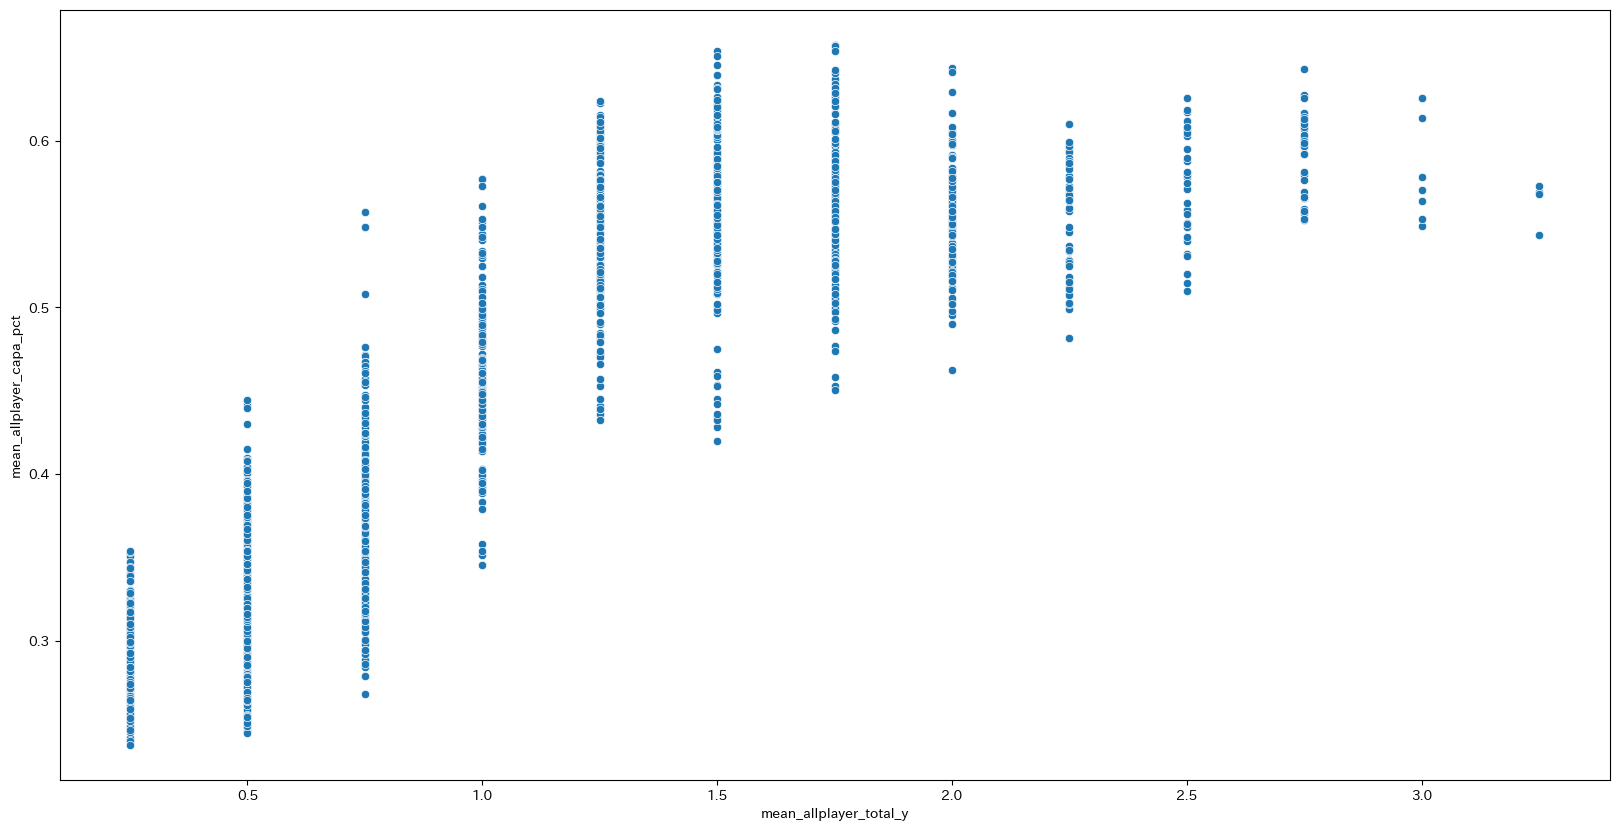

In [9]:
# For V4 submission, add total_y?
g_x = match_players["mean_allplayer_total_y"]
g_y = match_players["mean_allplayer_capa_pct"]
sns.scatterplot(x=g_x,y=g_y)

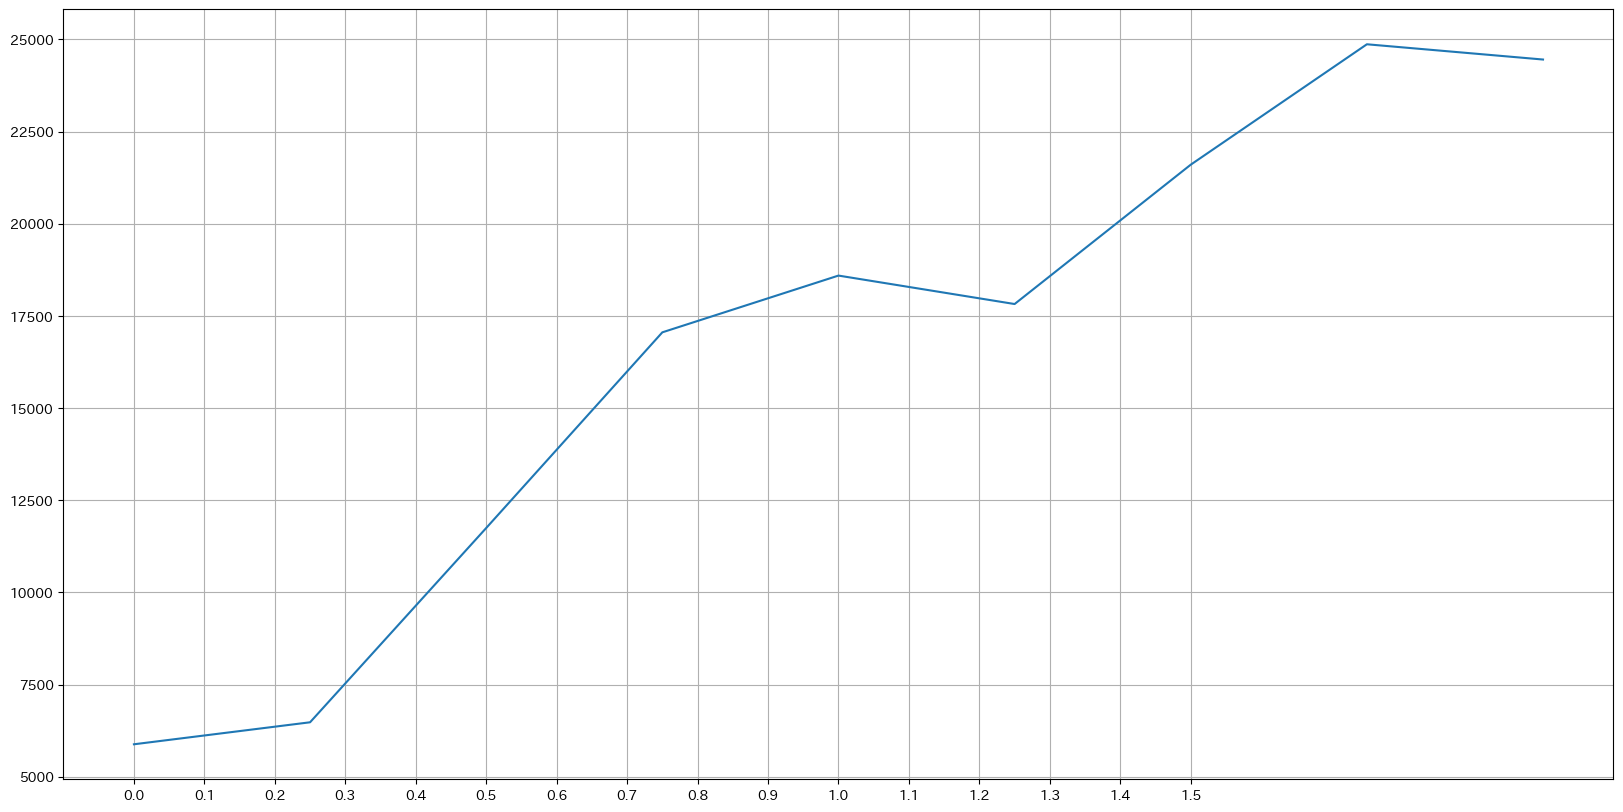

In [10]:
g_x = "mean_away_total_y"

g_dat = dat[dat["data"]=="Train"].groupby(g_x).agg({"y": ["mean", "count"]}).reset_index(drop=False)
g_dat.columns = [g_x, "y", "count"]
plt.plot(g_dat[g_x], g_dat["y"])
plt.grid()
plt.xticks([num * 0.1 for num in range(0, 16)]);
# process > 2.75

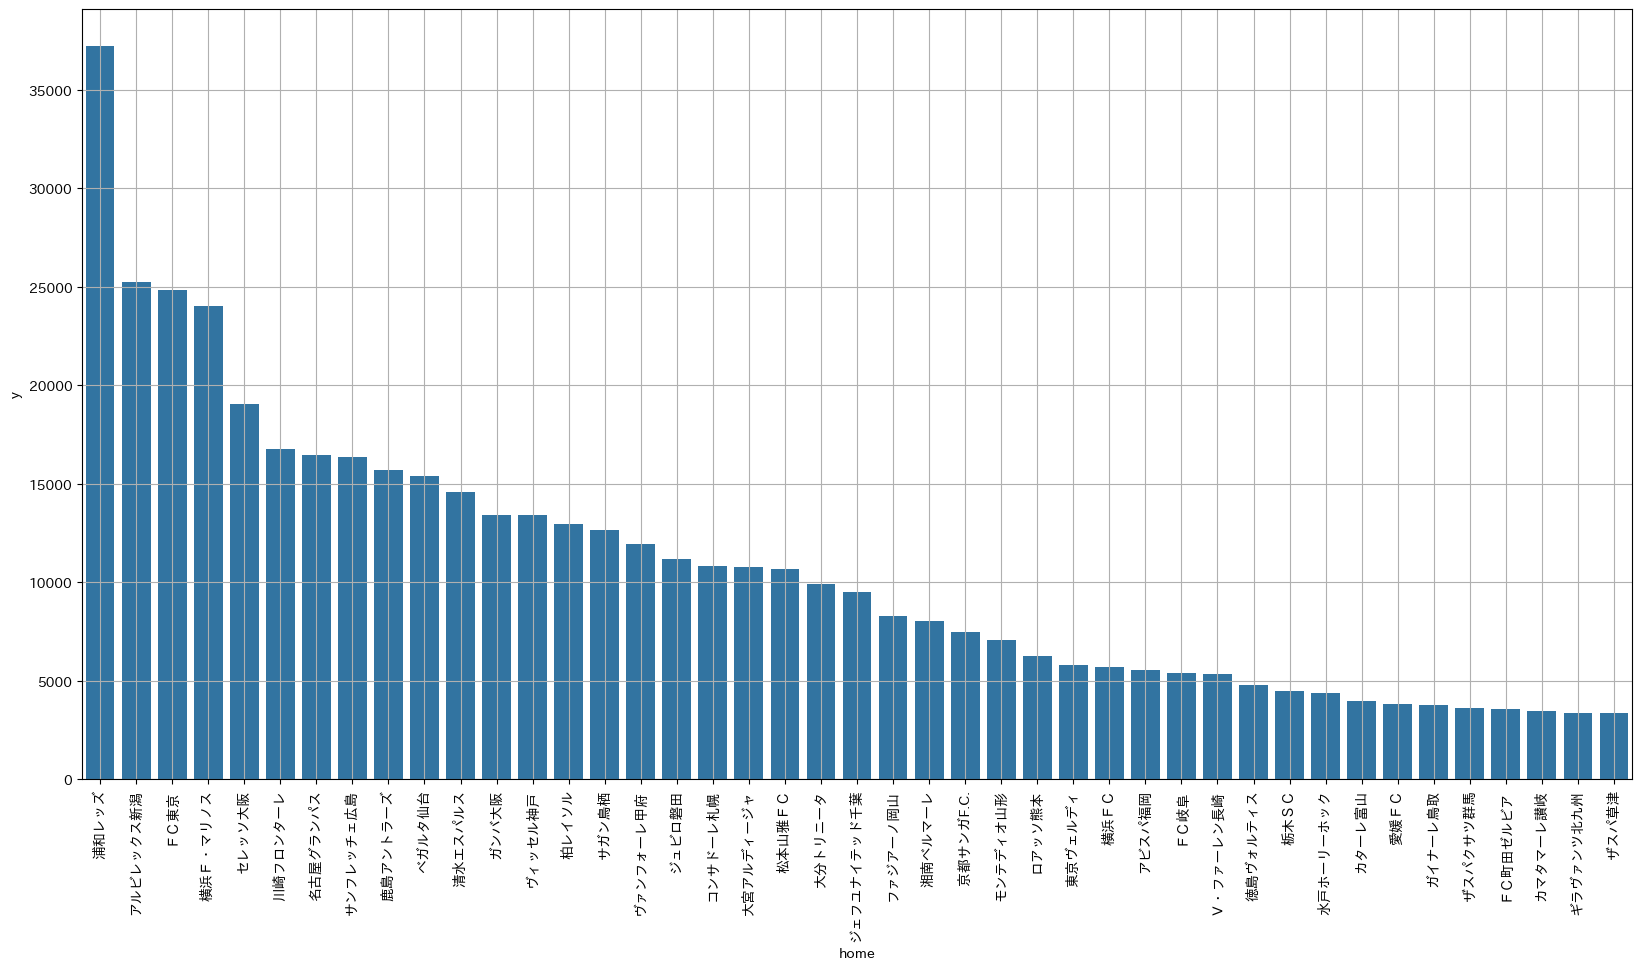

In [11]:
# Hot team matters?
gdat = dat.groupby("home").y.mean().reset_index().sort_values(by="y",ascending=False)

sns.barplot(gdat,x="home",y="y")
plt.xticks(rotation=90);
plt.grid()

In [12]:
# flagging teams
reds = gdat.query("y >= 30000")["home"].tolist()
top_home = gdat.query("30000 > y >= 17500")["home"].tolist()
mid_home = gdat.query("17500 > y >= 10000")["home"].tolist()

dat["home_flg"] = dat["home"].apply(lambda x: 3 if x in reds else 2 if x in top_home else 1 if x in mid_home else 0)
dat["away_flg"] = dat["away"].apply(lambda x: 3 if x in reds else 2 if x in top_home else 1 if x in mid_home else 0)
dat["match_flg"] = dat["home_flg"] + dat["away_flg"]
dat["large_stadium_flg"] = dat["capa"].apply(lambda x: 1 if x >= 40000 else 0)


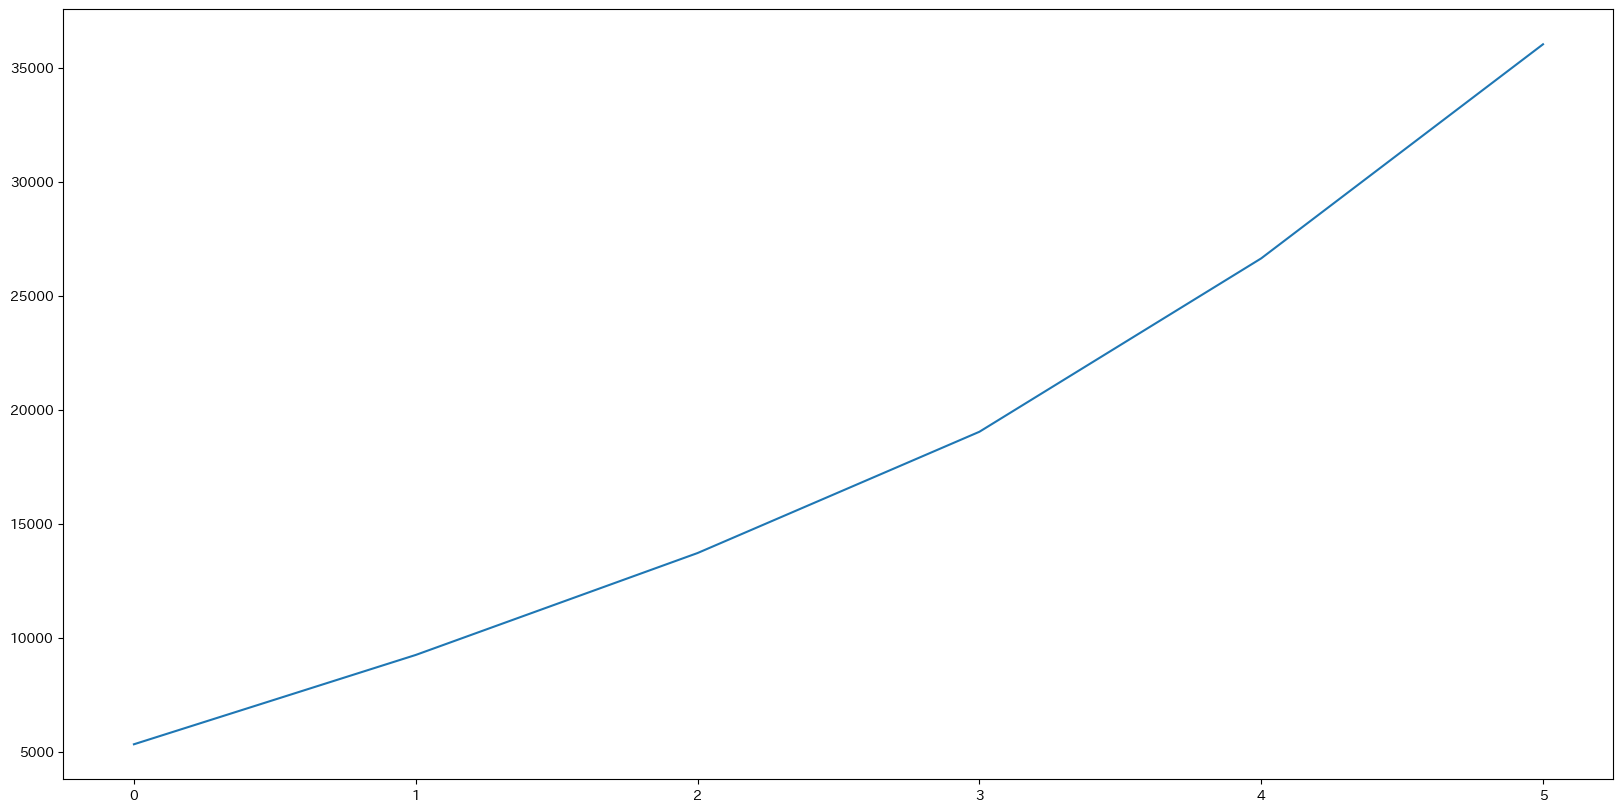

In [13]:
g_x = "match_flg"
g_dat = dat[dat["data"]=="Train"].groupby(g_x).agg({"y": ["mean", "count"]}).reset_index(drop=False)
g_dat.columns = [g_x, "y", "count"]
plt.plot(g_dat[g_x], g_dat["y"]);

In [14]:
# V5 submission, add match number, flagging last 2 match of J1 and J2, weekend flag?
dat['match_n'] = dat['match'].apply(lambda x: x.split('節')[0][1:]).astype(int)
dat['weekday'] = dat['gameday'].apply(lambda x: x[6])
dat['weekend_flg'] = dat["weekday"].apply(lambda x: 1 if x == "土" else 1 if x == "日" else 0)
dat["high_match_flg"] = dat.apply(lambda x: 1 if ((x["J1_flg"] == 1) & (x["match_n"] > 32) & (x["match_flg"] >= 3)) else 0,axis=1)
#dat.query("high_match == 1")[["capa","y","large_stadium_flg","home","away","match_n","year","stage"]]

## Set feature selector

In [15]:
sele = ["J1_flg", "December_flg", "attract_mean", "tv_N", "tv_NHK_flg", "capa_cate",
        'team_capa_pct_y','stadium_capa_pct_y', #V2
        "mean_home_capa_y","mean_away_capa_y","mean_allplayer_capa_y", #V3
        "match_flg","large_stadium_flg","mean_home_total_y","mean_away_total_y","mean_allplayer_total_y", #V4
        "match_n","weekend_flg","high_match_flg" #V5
       ]

## Check Multicollinearity
　多重共線性の確認は, 相関係数にて行う.

In [16]:
dat[sele].corr(method="spearman")

,J1_flg,December_flg,attract_mean,tv_N,tv_NHK_flg,capa_cate,team_capa_pct_y,stadium_capa_pct_y,mean_home_capa_y,mean_away_capa_y,mean_allplayer_capa_y,match_flg,large_stadium_flg,mean_home_total_y,mean_away_total_y,mean_allplayer_total_y,match_n,weekend_flg,high_match_flg
J1_flg,1.000000,0.133891,0.790086,0.101646,0.209780,0.302358,0.765238,0.733640,0.729359,0.706768,0.736374,0.869421,0.415878,0.784219,0.784418,0.849977,-0.163790,0.029119,0.131039
December_flg,0.133891,1.000000,0.108897,0.075267,0.100461,0.071273,0.110986,0.101212,0.104612,0.108903,0.109337,0.113205,0.091099,0.103563,0.094398,0.106618,0.142611,0.033272,0.461975
attract_mean,0.790086,0.108897,1.000000,0.076810,0.181601,0.514622,0.903806,0.938279,0.908432,0.743162,0.848302,0.832662,0.513025,0.890724,0.607676,0.836140,-0.130016,0.016891,0.123396
tv_N,0.101646,0.075267,0.076810,1.000000,0.486222,0.055264,0.068961,0.065115,0.047886,0.057221,0.046050,0.091761,0.068768,0.090836,0.114517,0.111332,-0.109360,0.045372,0.052156
tv_NHK_flg,0.209780,0.100461,0.181601,0.486222,1.000000,0.149342,0.206284,0.187992,0.193052,0.196809,0.199643,0.195822,0.150211,0.177094,0.175930,0.189977,-0.042172,0.070420,0.077638
capa_cate,0.302358,0.071273,0.514622,0.055264,0.149342,1.000000,0.709838,0.626020,0.724359,0.757667,0.759168,0.364305,0.738861,0.377333,0.246988,0.362647,-0.064055,0.015983,0.082513
team_capa_pct_y,0.765238,0.110986,0.903806,0.068961,0.206284,0.709838,1.000000,0.949329,0.975919,0.918043,0.975820,0.809272,0.654894,0.790781,0.655366,0.813678,-0.137975,0.019772,0.131311
stadium_capa_pct_y,0.733640,0.101212,0.938279,0.065115,0.187992,0.626020,0.949329,1.000000,0.958016,0.805039,0.902788,0.776376,0.618187,0.828142,0.573190,0.784412,-0.137934,0.016190,0.119566
mean_home_capa_y,0.729359,0.104612,0.908432,0.047886,0.193052,0.724359,0.975919,0.958016,1.000000,0.878267,0.963929,0.764298,0.674787,0.800189,0.570928,0.766907,-0.112911,0.026870,0.123739
mean_away_capa_y,0.706768,0.108903,0.743162,0.057221,0.196809,0.757667,0.918043,0.805039,0.878267,1.000000,0.969216,0.736070,0.678389,0.639576,0.677575,0.737314,-0.108491,0.018044,0.120814


## RMSE validation

In [17]:
from sklearn.model_selection import train_test_split
def rmse(y_actual, y_predicted):
    return np.sqrt(np.mean((y_predicted - y_actual) ** 2))

train = dat[(dat["data"]=="Train") & (dat["y"] > 0)].copy()
train_x = train[sele].copy()
train_y = train[["y"]].copy()

train_x, valid_x, train_y, valid_y= train_test_split(train_x, train_y, test_size=0.2, shuffle=False)
line_model = linear_model.LinearRegression().fit(train_x, train_y)
train_pred = line_model.predict(train_x)
valid_pred = line_model.predict(valid_x)
rmse(train_y, train_pred), rmse(valid_y, valid_pred)
# V3 (np.float64(3325.8692966966337), np.float64(3518.6294330183746)) - submit 3852.995659296009
# V4 (np.float64(3161.8644261851546), np.float64(3543.5848064646643)) - submit 3773.384015054846
# V5 (np.float64(3055.4329830339216), np.float64(3583.842557185702)) - submit 3694.0100191214115

(np.float64(3055.4329830339216), np.float64(3583.842557185702))

In [18]:
## RMSE with tree model?
from sklearn.tree import DecisionTreeRegressor
train_x = train[sele].copy()
train_y = train["y"].copy()

train_x, valid_x, train_y, valid_y= train_test_split(train_x, train_y, test_size=0.2, shuffle=False)

tree_model = DecisionTreeRegressor(
    criterion='absolute_error', #criterion{“squared_error”, “friedman_mse”, “absolute_error”, “poisson”},
    splitter="best",
    random_state=17,
    max_depth=None,
    #min_samples_split=2,
    #min_samples_leaf=1
)

tree_model = tree_model.fit(train_x, train_y)
train_pred = tree_model.predict(train_x)
valid_pred = tree_model.predict(valid_x)
rmse(train_y, train_pred), rmse(valid_y, valid_pred)
# V5 (np.float64(0.0), np.float64(4250.431984543754)) - submit 5059.92574419242

(np.float64(0.0), np.float64(4250.431984543754))

In [19]:
train_x = train[sele].copy()
train_y = train[["y"]].copy()
tree_model = DecisionTreeRegressor(
    criterion='absolute_error', #criterion{“squared_error”, “friedman_mse”, “absolute_error”, “poisson”},
    splitter="best",
    random_state=17,
    max_depth=None)
tree_model.fit(train_x,train_y)
train_pred = tree_model.predict(train_x)
train["pred"] = train_pred
train["pred - y"] = train["pred"] - train_y["y"]
train["abs(pred - y)"] = train["pred - y"].abs()
view_col = ["id","stage","match","match_flg","gameday","home","away","stadium","temperature","capa","y","pred","pred - y","abs(pred - y)","team_capa_pct_y","stadium_capa_pct_y"]
train[view_col].sort_values(by="abs(pred - y)",ascending=False).head(30)

,id,stage,match,match_flg,gameday,home,away,stadium,temperature,capa,y,pred,pred - y,abs(pred - y),team_capa_pct_y,stadium_capa_pct_y
0,13994,Ｊ１,第１節第１日,2,03/10(土),ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,3.8,19694,18250.0,18250.0,0.0,0.0,13663.336774,15351.315789
1,13995,Ｊ１,第１節第１日,2,03/10(土),名古屋グランパス,清水エスパルス,豊田スタジアム,12.4,40000,24316.0,24316.0,0.0,0.0,22105.827100,19498.650000
2,13996,Ｊ１,第１節第１日,2,03/10(土),ガンバ大阪,ヴィッセル神戸,万博記念競技場,11.3,21000,17066.0,17066.0,0.0,0.0,11669.852092,13406.175000
3,13997,Ｊ１,第１節第１日,4,03/10(土),サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,11.4,50000,29603.0,29603.0,0.0,0.0,24105.679577,16380.945946
4,13998,Ｊ１,第１節第１日,2,03/10(土),コンサドーレ札幌,ジュビロ磐田,札幌ドーム,22.5,39232,25353.0,25353.0,0.0,0.0,17827.800507,13545.076923
5,13999,Ｊ１,第１節第１日,3,03/10(土),サガン鳥栖,セレッソ大阪,ベストアメニティスタジアム,14.5,24490,11283.0,11283.0,0.0,0.0,14433.958972,13033.666667
6,14000,Ｊ１,第１節第１日,3,03/10(土),川崎フロンターレ,アルビレックス新潟,等々力陸上競技場,7.1,26530,18920.0,18920.0,0.0,0.0,15640.538285,16750.512821
7,14001,Ｊ１,第１節第１日,3,03/10(土),大宮アルディージャ,ＦＣ東京,ＮＡＣＫ５スタジアム大宮,9.2,15600,11437.0,11437.0,0.0,0.0,9899.039149,10817.371429
8,14002,Ｊ１,第１節第２日,3,03/11(日),柏レイソル,横浜Ｆ・マリノス,日立柏サッカー場,12.1,15349,13082.0,13082.0,0.0,0.0,10333.622740,11370.918919
9,14004,Ｊ１,第２節第１日,4,03/17(土),浦和レッズ,柏レイソル,埼玉スタジアム２００２,7.2,63700,41069.0,41069.0,0.0,0.0,35694.585970,37243.794872


In [20]:
train_x = train[sele].copy()
train_y = train[["y"]].copy()
model = linear_model.LinearRegression().fit(train_x, train_y)
train_pred = model.predict(train_x)

train["pred"] = train_pred
train["pred - y"] = train["pred"] - train_y["y"]
train["abs(pred - y)"] = train["pred - y"].abs()
view_col = ["id","stage","match","match_flg","gameday","home","away","stadium","temperature","capa","y","pred","pred - y","abs(pred - y)","team_capa_pct_y","stadium_capa_pct_y"]
train[view_col].sort_values(by="abs(pred - y)",ascending=False).head(30)
# nice weather x temperature flag?

,id,stage,match,match_flg,gameday,home,away,stadium,temperature,capa,y,pred,pred - y,abs(pred - y),team_capa_pct_y,stadium_capa_pct_y
1442,15765,Ｊ１,第１１節第１日,3,05/03(土・祝),名古屋グランパス,セレッソ大阪,豊田スタジアム,17.8,40000,38966.0,19865.570564,-19100.429436,19100.429436,23865.767723,19498.650000
1408,15725,Ｊ１,第７節第２日,3,04/12(土),セレッソ大阪,ガンバ大阪,ヤンマースタジアム長居,18.0,47816,42723.0,24997.406857,-17725.593143,17725.593143,30503.971063,28062.133333
693,14852,Ｊ１,第２節第１日,4,03/09(土),浦和レッズ,名古屋グランパス,埼玉スタジアム２００２,21.6,63700,52293.0,36583.156902,-15709.843098,15709.843098,36807.610462,37243.794872
1384,15698,Ｊ１,第４節第１日,3,03/23(日),鹿島アントラーズ,セレッソ大阪,県立カシマサッカースタジアム,13.9,40728,32099.0,16609.913367,-15489.086633,15489.086633,21078.702252,15710.888889
1417,15736,Ｊ１,第８節第１日,4,04/19(土),ＦＣ東京,セレッソ大阪,味の素スタジアム,13.2,49970,40761.0,25492.695707,-15268.304293,15268.304293,28508.089875,15409.031250
807,14982,Ｊ１,第１７節第１日,5,07/17(水),浦和レッズ,横浜Ｆ・マリノス,埼玉スタジアム２００２,24.1,63700,23725.0,38108.116203,14383.116203,14383.116203,38617.012940,37243.794872
917,15107,Ｊ１,第３１節第１日,4,11/10(日),ＦＣ東京,セレッソ大阪,味の素スタジアム,21.1,49970,40371.0,26153.281038,-14217.718962,14217.718962,28508.089875,15409.031250
1462,15787,Ｊ１,第１４節第１日,5,05/17(土),浦和レッズ,セレッソ大阪,埼玉スタジアム２００２,23.6,63700,54350.0,40396.764534,-13953.235466,13953.235466,39303.529785,37243.794872
715,14880,Ｊ１,第５節第１日,4,04/06(土),浦和レッズ,ジュビロ磐田,埼玉スタジアム２００２,15.6,63700,23295.0,37089.118375,13794.118375,13794.118375,36247.919476,37243.794872
834,15015,Ｊ１,第２０節第１日,1,08/10(土),大分トリニータ,柏レイソル,大分銀行ドーム,31.3,40000,23814.0,10573.942680,-13240.057320,13240.057320,15667.090514,9892.813953


## Make Model

In [21]:
# Train
train = dat[(dat["data"]=="Train") & (dat["y"] > 0)].copy()
train_x = train[sele].copy()
train_y = train[["y"]].copy()

# Test
test = dat[dat["data"]=="Test"].copy()
test_x = test[sele].copy()

# Learning
# Linear regression model
line_model = linear_model.LinearRegression()
line_model.fit(train_x, train_y)

# Decision tree model
tree_model = DecisionTreeRegressor(
    criterion='absolute_error', #criterion{“squared_error”, “friedman_mse”, “absolute_error”, “poisson”},
    splitter="best",
    random_state=17,
    max_depth=None)
tree_model.fit(train_x,train_y)

,criterion,'absolute_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,17
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


## Predict

In [22]:
line_pred = line_model.predict(test_x)
tree_pred = tree_model.predict(test_x)

## Predicted Value Correction

In [23]:
y_min = train_y.min()
y_min

y    1104.0
dtype: float64

In [24]:
def correction_fun_1(row):
    return max(row["pred"], 1104)

def correction_fun_2(row):
    return min(row["pred"], row["capa"])

pred_correction = test[["capa"]].copy()
pred_correction["pred"] = line_pred
pred_correction["pred"] = pred_correction.apply(correction_fun_1, axis=1)
pred_correction["pred"] = pred_correction.apply(correction_fun_2, axis=1)
pred_correction["pred"]

1720    13962.070885
1721    17066.090926
1722    34778.606803
1723    11367.274617
1724    25968.304116
            ...     
2028     4136.450569
2029     8236.886181
2030     4071.127158
2031     5768.105967
2032    11053.202562
Name: pred, Length: 313, dtype: float64

## Output

In [25]:
submit = test[["id"]].copy()
submit["pred"] = pred_correction["pred"]
submit.describe()

,id,pred
count,313.000000,313.000000
mean,16142.252396,11446.421777
std,224.441223,7576.561286
min,15822.000000,2326.317587
25%,15907.000000,5608.145708
50%,16261.000000,9490.579247
75%,16346.000000,14258.982541
max,16436.000000,44330.165140


In [26]:
submit.to_csv("../submit/20251021_submit_linear_v5.csv",  sep=",", index=False, header=False)
#submit.to_csv("../submit/20251021_submit_tree_v4.csv",  sep=",", index=False, header=False)

## Done!